In [1]:
from typing import List

import tensorflow as tf

from keras.utils import image_dataset_from_directory
from keras.layers import Rescaling
from keras.models import Model
from keras import layers
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
class Generator:
    def __init__(self, DIR: str = '/kaggle/input/covid19-xrays/Covid19-dataset',
                 category : List[str] = ['Covid', 'Normal', 'Viral Pneumonia'],
                 mode : str = 'categorical',
                 img_size : int = 256,
                 batch_size : int = 16,
                 shuffle : bool = True) -> None:
        self.DIR = DIR
        self.category = category
        self.mode = mode
        self.size = img_size
        self.batch = batch_size
        self.shuffle = shuffle

        self.norm = Rescaling(1./255)
    
    def __augment__(self, img):
        img = tf.image.random_flip_left_right(img)        
        img = tf.image.random_flip_up_down(img)

        return img
    
    def load_train(self):     
        train_ds = image_dataset_from_directory(directory= self.DIR + '/train',
                                                label_mode= self.mode,
                                                class_names= self.category,
                                                batch_size= self.batch,
                                                image_size= (self.size, self.size),
                                                shuffle= self.shuffle)           

        # Normalize And Cache
        train_ds = train_ds.map(lambda x, y: (self.norm(x), y),
                                num_parallel_calls= tf.data.AUTOTUNE)
        # Augment
        train_ds = train_ds.map(lambda x, y: (self.__augment__(x), y), 
                                num_parallel_calls= tf.data.AUTOTUNE)
        # Optimize
        train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
        
        return train_ds
    
    def load_test(self):
        test_ds = image_dataset_from_directory(directory= self.DIR + '/test',
                                                label_mode= self.mode,
                                                class_names= self.category,
                                                batch_size= 1,
                                                image_size= (self.size, self.size),
                                                shuffle= False)           

        # Normalize And Cache
        test_ds = test_ds.map(lambda x, y: (self.norm(x), y),
                                num_parallel_calls= tf.data.AUTOTUNE)
        test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

        return test_ds

In [3]:
class Xception:
    def __init__(self, shape, num_classes) -> None:
        self.shape = shape
        self.num_classes = num_classes

    def __entry__(self, inputs) :
        x = layers.Conv2D(32, 3, strides = 2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(64,3,padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        previous_block_activation = x

        for size in [128, 256, 728] :

            x = layers.Activation('relu')(x)
            x = layers.SeparableConv2D(size, 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)
            x = layers.SeparableConv2D(size, 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

            residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

            x = layers.add([x, residual])
            previous_block_activation = x

        return x

    def __middle__(self, x, num_blocks=8) :
        previous_block_activation = x

        for _ in range(num_blocks) :

            x = layers.Activation('relu')(x)
            x = layers.SeparableConv2D(728, 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)
            x = layers.SeparableConv2D(728, 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation('relu')(x)
            x = layers.SeparableConv2D(728, 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            x = layers.add([x, previous_block_activation])
            previous_block_activation = x

        return x
    
    def __exit__(self, x, activation= 'softmax') :
        previous_block_activation = x

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(1024, 3, padding='same')(x) 
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(1024, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(self.num_classes, activation= activation)(x)

        return x
    
    def load_model(self):
        input = layers.Input(shape= self.shape)

        x1 = self.__entry__(input)
        x2 = self.__middle__(x1)

        output = self.__exit__(x2)

        model = Model(input, output)
        return model

In [4]:
class FBeta(tf.keras.metrics.Metric):
    def __init__(self, name='f0.5_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.fb = self.add_weight(name='f_0.5', initializer='zeros')
        self.precision_fn = Precision()
        self.recall_fn = Recall()
        self.beta = 0.5

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        
        beta_sq = self.beta ** 2
        
        self.fb.assign((beta_sq + 1)*(p * r)/(beta_sq * p + r + K.epsilon()))

    def result(self):
        return self.fb

    def reset_state(self):
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.fb.assign(0)

In [5]:
train_ds = Generator().load_train()
val_ds = Generator().load_test()

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [6]:
train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

In [7]:
K.clear_session()

In [8]:
model = Xception(shape=(256, 256, 3), num_classes= 3).load_model()

In [9]:
early_stop = EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 5)

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5,  
                                            factor=0.5,                                            
                                            min_lr=0.000001)

In [11]:
model.compile(optimizer= 'adam', 
              loss= 'categorical_crossentropy', 
              metrics= [FBeta()])

In [12]:
model.fit(train_ds,
          validation_data= val_ds,
          epochs= 30,
          callbacks= [early_stop, learning_rate_reduction])

Epoch 1/30
16/16 [==============================] - 56s 436ms/step - loss: 1.0482 - f0.5_score: 0.6407 - val_loss: 1.0908 - val_f0.5_score: 0.0000e+00 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 7s 341ms/step - loss: 0.4031 - f0.5_score: 0.8701 - val_loss: 1.0918 - val_f0.5_score: 0.0000e+00 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 7s 280ms/step - loss: 0.2254 - f0.5_score: 0.9124 - val_loss: 1.0972 - val_f0.5_score: 0.0000e+00 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 7s 315ms/step - loss: 0.2425 - f0.5_score: 0.9033 - val_loss: 1.1052 - val_f0.5_score: 0.0000e+00 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 7s 294ms/step - loss: 0.2204 - f0.5_score: 0.9222 - val_loss: 1.1177 - val_f0.5_score: 0.0000e+00 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 7s 323ms/step - loss: 0.1701 - f0.5_score: 0.9313 - val_loss: 1.1441 - val_f0.5_score: 0.3939 - lr: 0.0010


In [13]:
import pandas as pd

<Axes: >

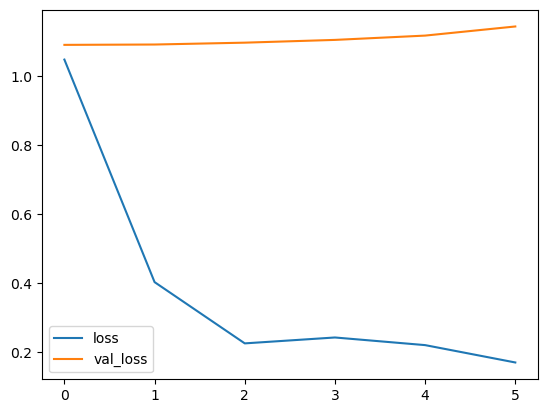

In [14]:
hist = pd.DataFrame(model.history.history)
hist.drop(['f0.5_score', 'val_f0.5_score', 'lr'], axis= 1, inplace= True)

hist.plot()

In [15]:
K.clear_session()

del train_ds
del val_ds

import gc
gc.collect()

118